# Creando la base de datos de vectores chromadb

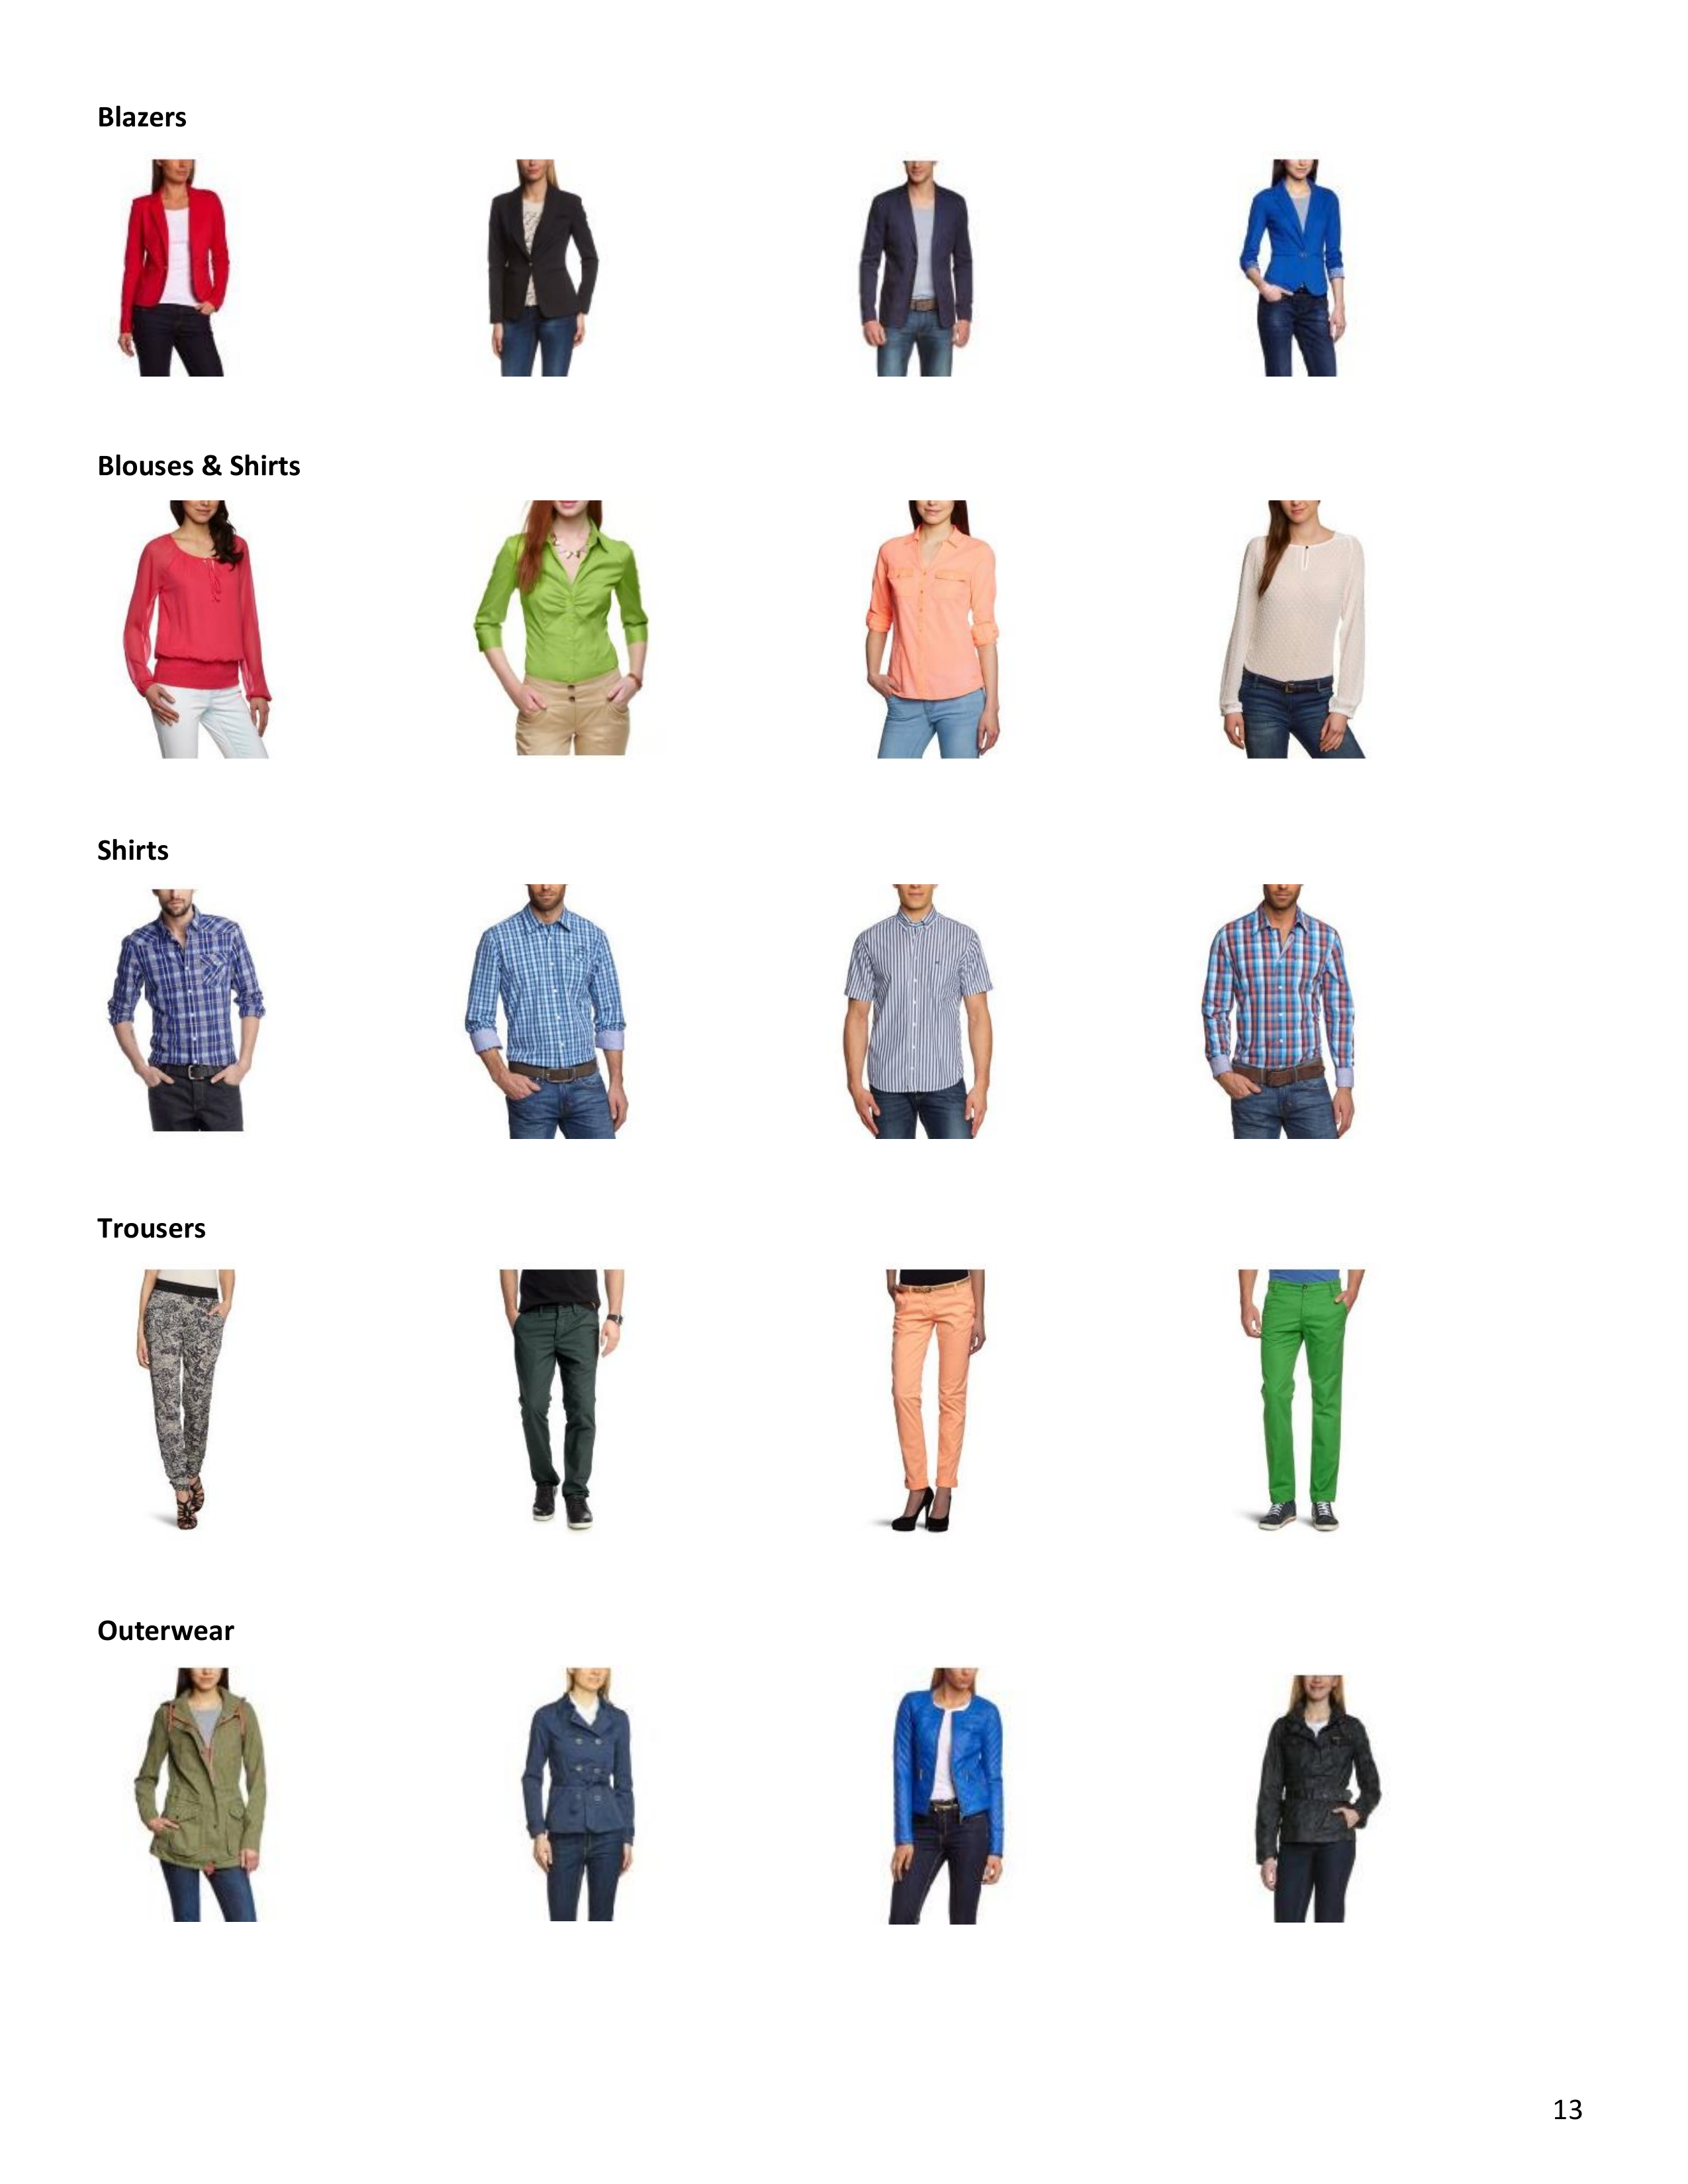

In [2]:
# Vemos como convertir un PDF a una imagen
import pdf2image #1.17.0

doc_img = pdf2image.convert_from_path("data/Clothing_Styleguide_Amazon.pdf", dpi=300)

# Pagina 13
doc_img[12]

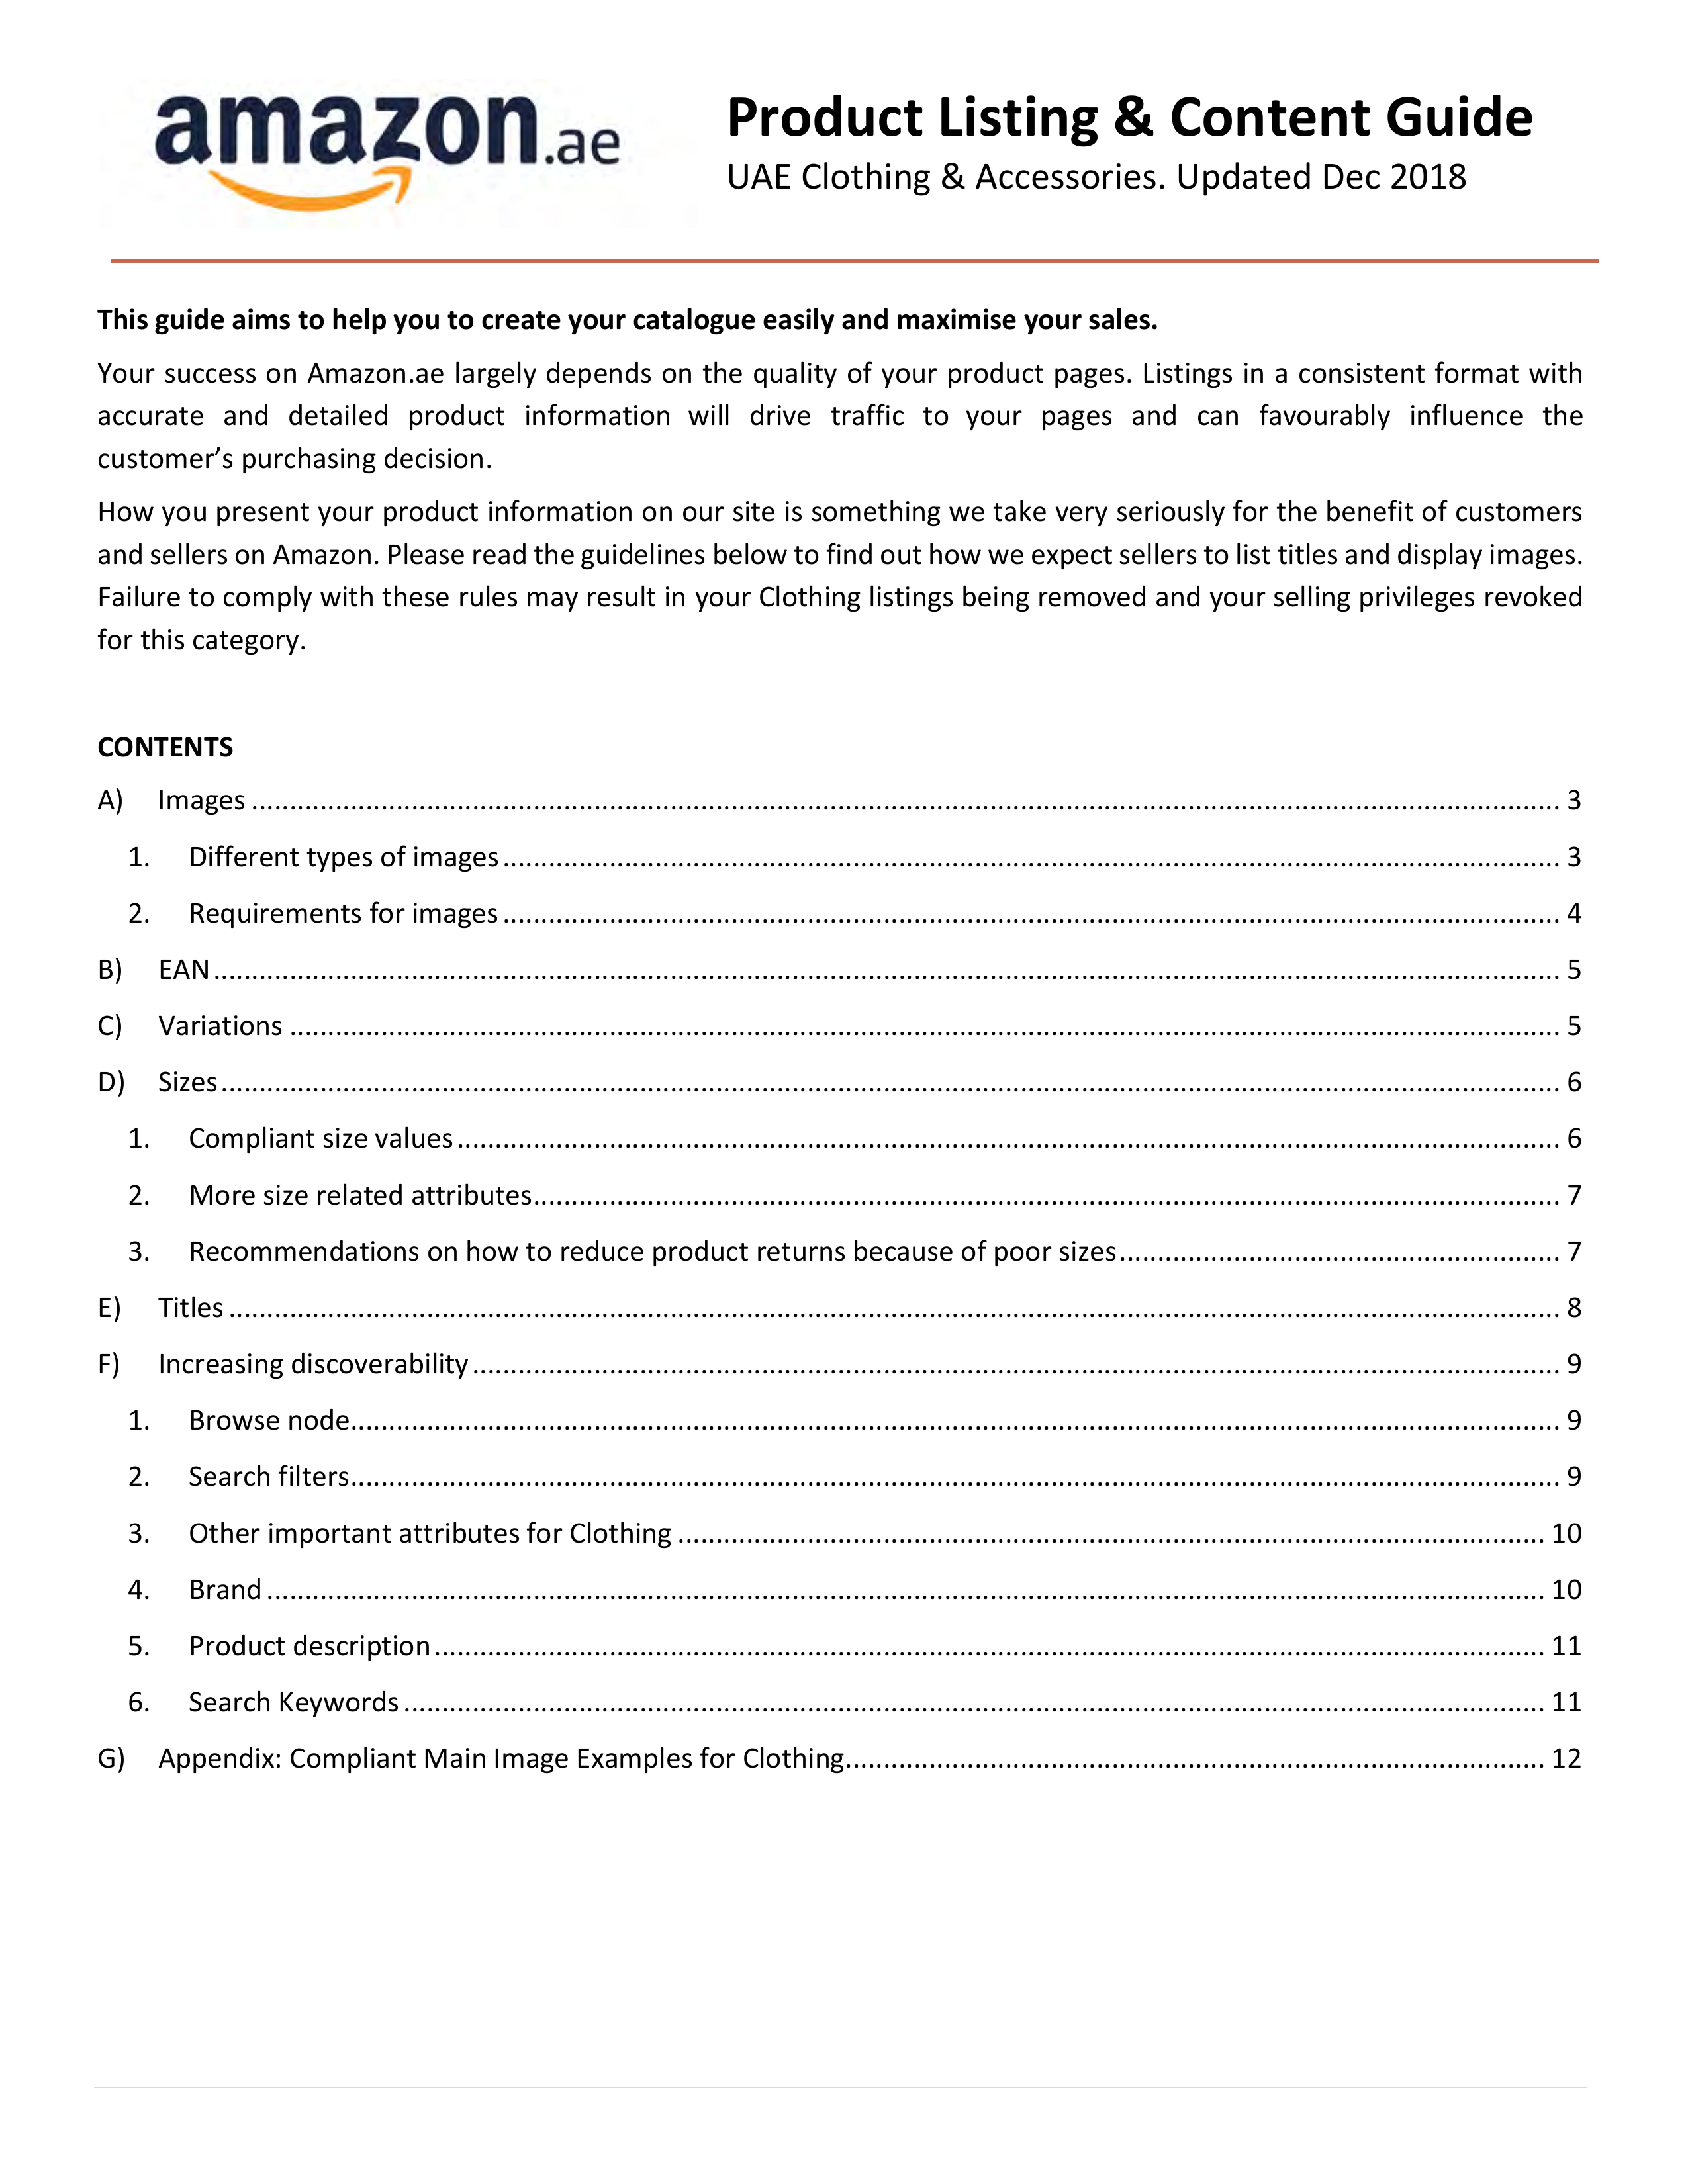

In [5]:
doc_img[1]

In [3]:
# Para esto necesitamos instalar tesseract y pytesseract, además colocar la ruta de tesseract en el PATH
# Pasamos la imagen a texto en este paso
import pytesseract #0.3.10

doc_txt = []
for page in doc_img:
    text = pytesseract.image_to_string(page)
    doc_txt.append(text)

doc_txt[2]

"A) Images\n\nGood images communicate selling points and features of your product, inform and interest customers, and reinforce\nyour brand.\n\nIn an online store, the product image is one of your most valuable marketing tools. Listings with low-quality or few images\nsuffer poor conversion rates and over time will appear less and less frequently in search rankings. The best customer\nexperience is a store that is visually clean and consistent, so we require all sellers to commit to and maintain the standards\ndescribed in this guide.\n\nImportant: Listings may be suppressed if they do not meet al! required imaging standards. These listings will continue\nto be visible in your Seller Central account and accessible from the Suppressed Listings view in Manage Inventory where\nyou can upload compliant images and information.\n\nWe recommend you to regularly check your Listing Quality and Suppressed Listing Report to identify detected by\nAmazon opportunities to improve image quality of yo

In [3]:
print(doc_txt[2])

A) Images

Good images communicate selling points and features of your product, inform and interest customers, and reinforce
your brand.

In an online store, the product image is one of your most valuable marketing tools. Listings with low-quality or few images
suffer poor conversion rates and over time will appear less and less frequently in search rankings. The best customer
experience is a store that is visually clean and consistent, so we require all sellers to commit to and maintain the standards
described in this guide.

Important: Listings may be suppressed if they do not meet al! required imaging standards. These listings will continue
to be visible in your Seller Central account and accessible from the Suppressed Listings view in Manage Inventory where
you can upload compliant images and information.

We recommend you to regularly check your Listing Quality and Suppressed Listing Report to identify detected by
Amazon opportunities to improve image quality of your listings.

1.

In [9]:
# Procesamos el texto para obtener los párrafos, en este paso
# se utiliza un diccionario para mapear los títulos de las secciones
# con los números de página en el PDF
# luego se extraen los párrafos y se les asigna un ID único y un título,
# estos metadatos funcionan para dar contexto a los párrafos, suele venir bien
# para que la busqueda en la base de datos de vectores sea más precisa
title_map = {
    "3-4": "A) Images",
    "5": "C) Variations",
    "6-7": "D) Sizes",
    "8": "E) Titles",
    "9-11": "F) Increasing discoverability"
}

lst_docs, lst_ids, lst_metadata = [], [], []
for n, page in enumerate(doc_txt):
    try:
        ## get title(s)
        titles = [v if isinstance(v, list) else [v] for k, v in title_map.items()
                  if n in range(int(k.split('-')[0]), int(k.split('-')[-1]) + 1)]
        titles = [item for sublist in titles for item in sublist]  # Flatten list
        ## clean page
        page = page.replace("Table of Contents", "")
        ## get paragraph
        for i, p in enumerate(page.split('\n\n')):
            if len(p.strip()) > 5:  # clean paragraph
                for title in titles:
                    lst_docs.append(p.strip())
                    lst_ids.append(f"{n}_{i}")
                    lst_metadata.append({"title": title})
    except Exception as e:
        print(f"Error processing page {n}: {str(e)}")
        continue

## print example
for id, doc, meta in zip(lst_ids, lst_docs, lst_metadata):
    print(id, "-", meta, "\n", doc, "\n")

3_0 - {'title': 'A) Images'} 
 2. Requirements for images 

3_1 - {'title': 'A) Images'} 
 Y Required for MAIN Every item must have a MAIN image for the parent ASIN as well as for each child ASIN
images: (Colour / Size Variation).
MAIN image must be on a pure white background (Hex #FFFFFF or RGB 255-255-255).
MAIN image for clothing must be shot on a Model (except for Children clothing, accessories
and transparent products). Other allowed but less preferable options are to shot clothing
onan “invisible” (“ghost”) mannequin or flat.
MAIN image must show one and front product view.
MAIN image must show only the product for sale (without extra accessories).
MAIN image must show the entire product (no product parts could be clipped).
MAIN image must have an aspect ratio close to 3:4 (Width:Height), and the product must
occupy at least 85% of the image area in its longest dimension.
for ALL Images must be high resolution professional photos with 1,000 pixels or larger in either
images: heig

In [5]:
# Debes tener instalado el paquete ollama, este es un ejemplo de cómo se obitnen palabras clave de un párrafo
import ollama #0.2.1

def keyword_generator(p, top=3):
    prompt = "summarize the following paragraph in 3 keywords separated by ,: "+p
    res = ollama.generate(model="phi3", prompt=prompt)["response"]
    return res.replace("\n"," ").strip()


## test
p = '''Professional artists, architects and designers use NVIDIA partner products accelerated with our GPUs and software platform for a range of creative and design
use cases, such as creating visual effects in movies or designing buildings and products. In addition, generative Al is expanding the market for our workstation-
class GPUs, as more enterprise customers develop and deploy Al applications with their data on-premises.'''
print(keyword_generator(p))


Professional artists, architectural computing, AI acceleration.


In [ ]:
# Generamos las palabras clave para cada párrafo del documento
from tqdm.notebook import tqdm # Nos sirve para ver el progreso de cada iteración, las iteraciones son el numero de párrafos

# Añadimos las palabras clave a los metadatos
for i,doc in tqdm(enumerate(lst_docs)):
    lst_metadata[i]["keywords"] = keyword_generator(doc)

## print example
for id,doc,meta in zip(lst_ids[375:378], 
                       lst_docs[375:378], 
                       lst_metadata[375:378]):
    print(id, "-", meta, "\n", doc, "\n")

In [ ]:
import chromadb #0.5.0

db = chromadb.PersistentClient() # Creamos o nos conectamos a la base de datos local

# Creamos una colección en la base de datos, esta colección se llama Amazon_Styleguide
collection_name = "Amazon_Styleguide"
collection = db.get_or_create_collection(name=collection_name, 
               embedding_function=chromadb.utils.embedding_functions.DefaultEmbeddingFunction())

In [3]:
import chromadb #0.5.0

In [4]:
db = chromadb.PersistentClient() # Creamos o nos conectamos a la base de datos local

In [ ]:
# Lista de ids de los documentos
lst_ids

In [ ]:
# Añadimos los documentos a la colección de la base de datos, los documentos son los párrafos, los ids son los ids únicos de cada párrafo
# y los metadatos son los metadatos de cada párrafo
collection.add(documents=lst_docs, ids=lst_ids, metadatas=lst_metadata, 
               images=None, embeddings=None)

# Vemos el segundo embedding de la colección
collection.peek(1)

In [ ]:
# Hacemos una consulta a la base de datos, en este caso buscamos los párrafos que contienen la palabra "discoverability"
query = "How could I increase the discoverability of my products?"
collection.query(query_texts=[query])

In [ ]:
# Este sería el contexto que le pasamos a un LLM para que genere una respuesta con información del documento
res_db = collection.query(query_texts=[query])["documents"][0][0:10]
context = ' '.join(res_db).replace("\n", " ")
context